In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('C:/Users/kaczm/project_git/Bidding-CPM-Prediction/dataset/cpm_prediction.csv')

In [2]:
# first let's start off with XGBoost, then let's try RF

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y = df['CPM']
X = df.drop(columns = ['CPM'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

def XGBoost_model(X_train, y_train, X_test, y_test):
    model = XGBRegressor(objective='reg:squarederror', random_state=42) # I will be tuning the parameters on the go
    model.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = model.predict(X_test)
    
    # Printing metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    
    return model

In [3]:
xgb_model = XGBoost_model(X_train, y_train, X_test, y_test)

Root Mean Squared Error: 143.24679325604657
Mean Absolute Error: 7.046851970078372


site_id : 0.08532096
ad_type_id : 0.013586768
geo_id : 0.0024225444
device_category_id : 0.018806277
advertiser_id : 9.264672e-05
os_id : 0.0021213458
integration_type_id : 0.0
monetization_channel_id : 4.681785e-05
ad_unit_id : 0.00243911
total_impressions : 0.1638682
total_revenue : 0.56109905
viewable_impressions : 0.0019154042
measurable_impressions : 0.13542004
revenue_share_percent : 0.0
measurable_to_total_imps : 0.00042235214
viewable_to_total_imps : 0.01166986
actual_revenue : 0.0
week : 0.0007685777
month : 0.0


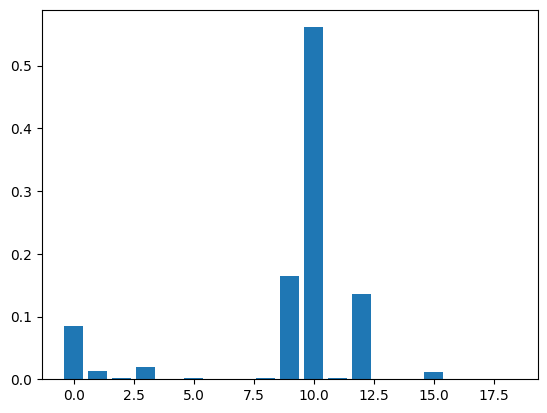

In [4]:
# lets check out this model
import matplotlib.pyplot as plt 

# Feature importance
importance = xgb_model.feature_importances_
for i,j in enumerate(importance):
    print(X_train.columns[i],":", j)

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [5]:
# total revenue has a very strong effect on the model - let's see correlations


correlations = df.corr()['CPM'].sort_values(ascending=False)
print(correlations)

CPM                         1.000000
total_revenue               0.084538
actual_revenue              0.084538
ad_type_id                  0.061719
geo_id                      0.056828
viewable_to_total_imps      0.040822
ad_unit_id                  0.027816
viewable_impressions        0.009622
total_impressions           0.000674
measurable_impressions      0.000615
measurable_to_total_imps   -0.003742
week                       -0.006392
site_id                    -0.009248
advertiser_id              -0.016978
os_id                      -0.023717
device_category_id         -0.024757
monetization_channel_id    -0.028133
integration_type_id              NaN
revenue_share_percent            NaN
month                            NaN
Name: CPM, dtype: float64


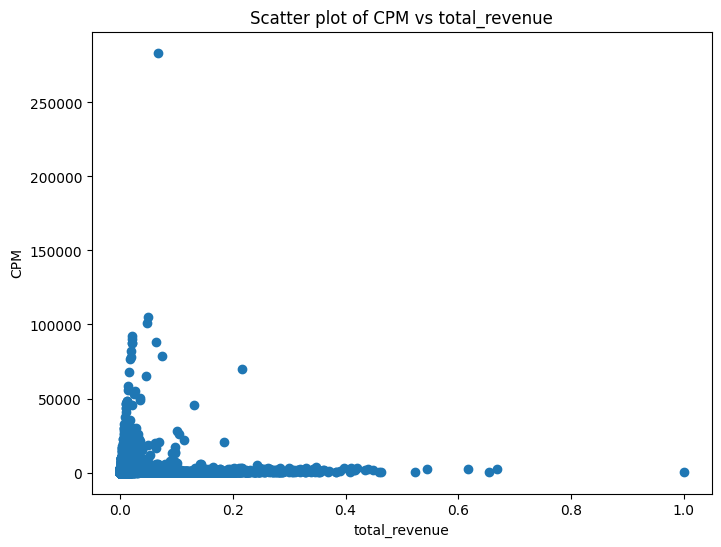

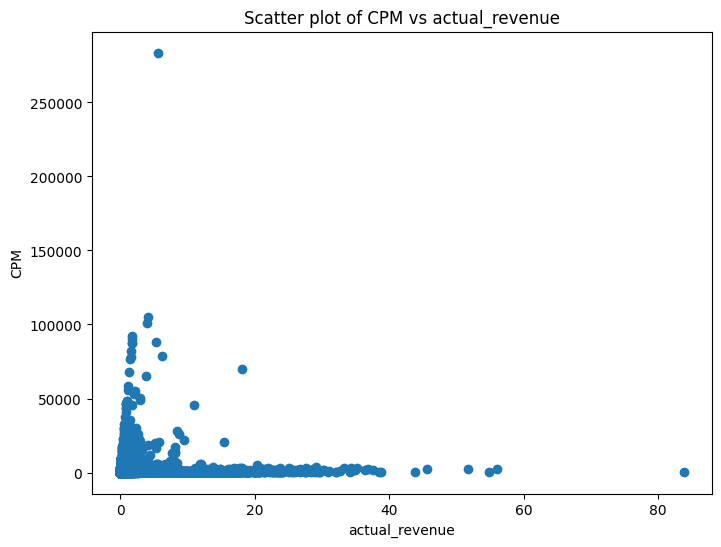

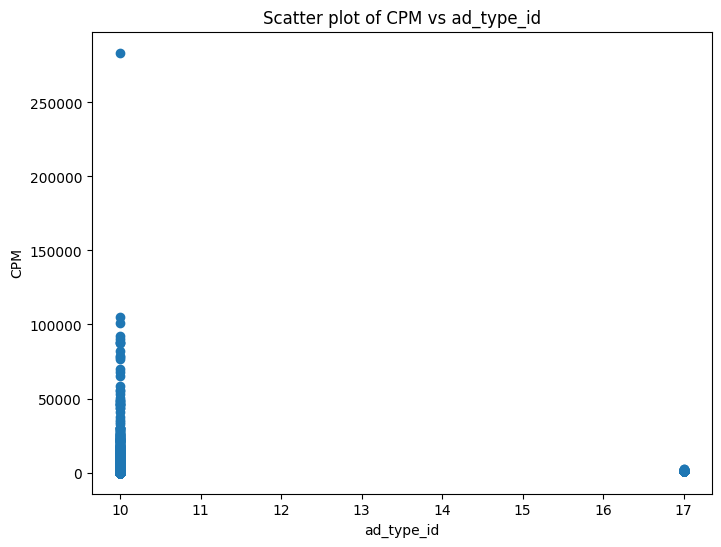

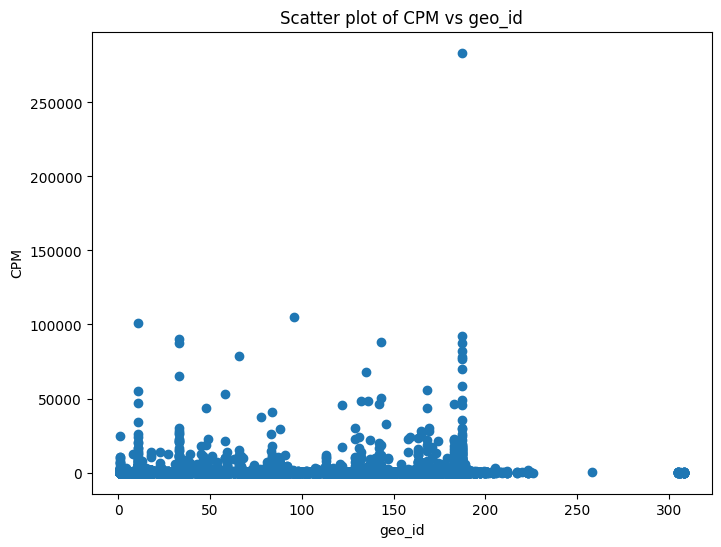

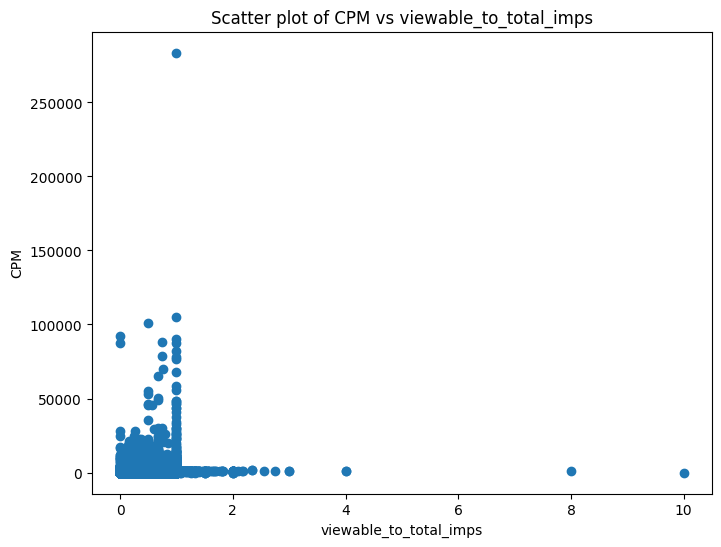

In [10]:
# let's also plot those variables on scatter plot against each other

top_features = correlations.index[1:6]  # Excluding 'CPM' itself

# Create scatter plots
for feature in top_features:
    plt.figure(figsize=(8,6))
    plt.scatter(df[feature], df['CPM'])
    plt.title(f'Scatter plot of CPM vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('CPM')
    plt.show()

In [6]:
# now let's do some random forest

from sklearn.ensemble import RandomForestRegressor

def RandomForest_model(X_train, y_train, X_test, y_test, n_estimators=100, random_state=42):
    # Initialize the model
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    
    # fit the model
    model.fit(X_train, y_train)

    # predicting the Test set results
    y_pred = model.predict(X_test)
    
    # printing metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    
    return model

# Use the function to train the model and get predictions
rf_model = RandomForest_model(X_train, y_train, X_test, y_test)

# very interesting - seems like this model generalizes better, but occassionaly makes bigger mistakes than XGBoost 

Root Mean Squared Error: 420.80157725409407
Mean Absolute Error: 5.23230364917595


In [7]:
# I want to investigate a little why this model makes those large mistakes

def large_errors_rf(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Create a DataFrame from the test data
    df_test = pd.DataFrame(X_test)

    # Add the actual and predicted values to the DataFrame
    df_test['Actual'] = y_test
    df_test['Predicted'] = y_pred

    # Calculate the absolute error
    df_test['Error'] = abs(df_test['Actual'] - df_test['Predicted'])

    # now inspect the rows where the error is large
    # This will show us the top 10 instances where the model's predictions had the largest errors
    large_errors = df_test.sort_values('Error', ascending=False).head(10)

    print(large_errors)

    return large_errors

x = large_errors_rf(rf_model, X_test, y_test)

# advertiser_id, integration_type_id and monetization_channel_id are all the same for those errors

        site_id  ad_type_id  geo_id  device_category_id  advertiser_id  os_id  \
193526      342          10     143                   1             79     56   
124876      349          10     187                   1             79     56   
189730      346          10      11                   3             79     55   
210465      342          10      33                   1             79     56   
21705       346          10     129                   1             79     56   
159507      351          10     187                   2             79     58   
77435       346          10     168                   3             79     55   
220119      350          10      33                   1             79     56   
44862       350          10      33                   3             79     59   
160595      349          10     187                   2             79     60   

        integration_type_id  monetization_channel_id  ad_unit_id  \
193526                    1             

In [8]:
# I will also try linear regression 

from sklearn.linear_model import LinearRegression
def train_linear_regression(X_train, y_train, X_test, y_test):
    # initialize the Linear Regression model
    model = LinearRegression()

    # train the model
    model.fit(X_train, y_train)

    # use the model to predict the test set
    y_pred = model.predict(X_test)
    
    # calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    
    return model

# call the function
lr_model = train_linear_regression(X_train, y_train, X_test, y_test)

# LR is evidently now the way to go

Root Mean Squared Error: 869.8809332746004
Mean Absolute Error: 219.56607098803852


In [11]:
df

,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent,CPM,measurable_to_total_imps,viewable_to_total_imps,actual_revenue,week,month
0,351,10,187,3,8,59,1,4,5177,0.011488,0.004417,0.011364,0.012069,1,220.476190,1.000000,0.500000,0.3704,26,6
1,351,10,187,3,8,55,1,4,5177,0.002215,0.001141,0.002165,0.002327,1,281.764706,1.000000,0.470588,0.0958,26,6
2,351,10,187,2,8,58,1,4,5177,0.000138,0.000840,0.000271,0.000145,1,1765.000000,1.000000,0.500000,0.0706,26,6
3,351,10,187,1,8,56,1,4,5177,0.000138,0.000007,0.000271,0.000145,1,20.000000,1.000000,0.500000,0.0008,26,6
4,351,10,173,3,8,59,1,4,5177,0.000138,0.000007,0.000000,0.000145,1,20.000000,1.000000,0.000000,0.0008,26,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270612,350,10,187,3,79,59,1,19,5168,0.000692,0.000301,0.000541,0.000727,1,211.666667,1.000000,0.333333,0.0254,22,6
270613,350,10,187,1,79,56,1,19,5168,0.004567,0.004054,0.007035,0.004653,1,515.151515,0.970588,0.764706,0.3400,22,6
270614,350,10,158,1,79,56,1,19,5168,0.000000,0.000052,0.000000,0.000000,1,230.000000,1.000000,0.000000,0.0046,22,6
270615,350,10,33,1,79,56,1,19,5168,0.000277,0.000141,0.000000,0.000291,1,200.000000,1.000000,0.000000,0.0120,22,6


In [21]:
# I kindaa want to do some NN as well just to see how they perform for this task

# we first need to deal with those large categorical columns such as geo_id. Best way will be through embeddings I think
# since the number of categories is really large

df['geo_id'].nunique()


212

In [28]:
df['site_id'] = pd.factorize(df['site_id'])[0]
df['ad_type_id'] = pd.factorize(df['ad_type_id'])[0]
df['ad_unit_id'] = pd.factorize(df['ad_unit_id'])[0]
df['monetization_channel_id'] = pd.factorize(df['monetization_channel_id'])[0]
df['advertiser_id'] = pd.factorize(df['advertiser_id'])[0]
df['device_category_id'] = pd.factorize(df['device_category_id'])[0]
df['os_id'] = pd.factorize(df['os_id'])[0]
df['integration_type_id'] = pd.factorize(df['integration_type_id'])[0]
df['geo_id'] = pd.factorize(df['geo_id'])[0]

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, concatenate

# Define input columns
input_columns = ['site_id', 'ad_type_id', 'geo_id', 'device_category_id', 'advertiser_id', 
                 'os_id', 'integration_type_id', 'monetization_channel_id', 'ad_unit_id']

# Define the rest of the columns that will not be embedded
other_columns = [col for col in df.columns if col not in input_columns + ['CPM']]

# Define embeddings
embeddings = []
inputs = []

for column in input_columns:
    # get the number of unique values in the column
    unique_values = df[column].nunique()

    # define the embedding size
    embedding_size = min(max(2, int(np.sqrt(unique_values))), 50)
    
    # Define the input layer
    input_layer = Input(shape=(1,), name=f'{column}_input')
    inputs.append(input_layer)
    
    # define the embedding layer
    embedding = Embedding(input_dim=unique_values+1, output_dim=embedding_size, 
                          input_length=1, name=f'{column}_embedding')(input_layer)
    embedding = Flatten()(embedding)
    
    embeddings.append(embedding)

# also create inputs for the rest of the columns and append them to the list of inputs
for column in other_columns:
    input_layer = Input(shape=(1,), name=f'{column}_input')
    inputs.append(input_layer)
    embeddings.append(input_layer)

# Concatenate all embeddings and the other inputs
x = concatenate(embeddings)

# define the rest of model architecture (Dense layers, etc.)
x = Dense(128, activation='relu')(x)
output = Dense(1)(x) # this is an example for a regression task

# Define the model
model = Model(inputs=inputs, outputs=output)

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error') # adjust according to your specific task

# summarize the model
model.summary()



Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 site_id_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 ad_type_id_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 geo_id_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 device_category_id_input (Inpu  [(None, 1)]         0           []                               
 tLayer)                                                                                   

In [58]:
target = 'CPM'

# Prepare input data as a list of numpy arrays
input_data = [df[column].values for column in input_columns + other_columns]
input_data = np.column_stack(input_data)
target_data = df[target].values


# Split data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

# Convert each part of the split data into the appropriate format
X_train = [X_train[:, i] for i in range(X_train.shape[1])]
X_test = [X_test[:, i] for i in range(X_test.shape[1])]
y_train = np.array(y_train)
y_test = np.array(y_test)

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)



Epoch 1/10
6766/6766 [==============================] - 26s 3ms/step - loss: 1176052.3750 - val_loss: 759517.9375
Epoch 2/10
6766/6766 [==============================] - 23s 3ms/step - loss: 1165020.3750 - val_loss: 753755.4375
Epoch 3/10
6766/6766 [==============================] - 24s 4ms/step - loss: 1160318.7500 - val_loss: 749796.0000
Epoch 4/10
6766/6766 [==============================] - 24s 4ms/step - loss: 1156563.6250 - val_loss: 745438.1875
Epoch 5/10
6766/6766 [==============================] - 24s 3ms/step - loss: 1152820.0000 - val_loss: 740658.1875
Epoch 6/10
6766/6766 [==============================] - 23s 3ms/step - loss: 1148630.0000 - val_loss: 736310.5000
Epoch 7/10
6766/6766 [==============================] - 23s 3ms/step - loss: 1144386.3750 - val_loss: 730940.0000
Epoch 8/10
6766/6766 [==============================] - 23s 3ms/step - loss: 1139419.3750 - val_loss: 725503.4375
Epoch 9/10
6766/6766 [==============================] - 23s 3ms/step - loss: 1134239.750

In [ ]:
# well, we can see that while the loss has been going down and we could experiment with the network, adding more layers
# changing learning rate and using regulirizarion techniques, I'm not sure it would yield better results than the ML algorithms I 
# checked out earlier